## Binary Quantization

* 벡터의 각 차원을 1비트로 변환하여 메모리 절약
* 양수는 1, 음수는 0으로 변환하여 방향성만 유지
* 메모리 효율성과 처리 속도를 높이지만, 정확도가 떨어질 수 있음
* similarity search 진행 시, oversampling 후 re-ranking 하는 방식으로 보완 가능

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import time

f = h5py.File('openai_embedding_output.hdf5','r')
distances = f['distances']
neighbors = f['neighbors']
test = f['test']
train = f['train']

In [4]:
import numpy as np
from scipy.spatial.distance import hamming, cosine

### example code ###

class BinaryQuantization:
    def __init__(self, vectors):
        self.vectors = self.binary_quantization(vectors)

    def binary_quantization(self, vectors):
        return np.where(vectors >= 0, 1, 0)

    def search(self, query, k):
        query_bin = self.binary_quantization(query)
        distances = np.array([hamming(query_bin, vec_bin) for vec_bin in self.vectors])
        closest_index = np.argsort(distances)[:k]
        return [(idx, distances[idx]) for idx in closest_index]


In [5]:
bq = BinaryQuantization(train[:])

In [6]:
bq.search(test[0], 5)

[(199, 0.263671875),
 (270, 0.2734375),
 (520, 0.2786458333333333),
 (791, 0.28125),
 (498, 0.2916666666666667)]

In [7]:
[(n, d) for d, n in zip(distances[0][:5], neighbors[0][:5])]

[(791, 0.18023627996444702),
 (199, 0.18199849128723145),
 (270, 0.19761407375335693),
 (498, 0.20239192247390747),
 (320, 0.20566928386688232)]

In [8]:
## search speed and accuracy
accuracies_bq = []
times = []

for i in range(len(test)):
    start = time.time()
    search_result = bq.search(test[i], 5)
    times.append(time.time() - start)

    acc = len(set(neighbors[i][:5]) & set([idx for idx, _ in search_result])) / 5
    accuracies_bq.append(acc)

print(f"accuracy : {np.mean(accuracies_bq)}, qps : {1 / np.mean(times)}")


## BQ만으로는 성능 부족 => over-filtering 후 re-ranking 필요

accuracy : 0.682, qps : 121.28617646004209


## Homework (2024.11.20 (수) 11:59 PM 까지)

*   해당 파일에 작성하여 제출
*   파일명: homework_이름_학번.ipynb




1. IVF, HNSW에 binary quantization 적용
    *   index build or search (cf. IVF-PQ, HNSW-PQ)
    *   구현 방식에 대한 간략한 설명


In [40]:

import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize


class IVF:

    def _compute_distance(self, data, q):
        """Compute the appropriate distance based on the distance type."""
        if self.distance_type == 'l2':
            return np.linalg.norm(data - q, axis=1)
        elif self.distance_type == 'cosine':
            return 1 - np.dot(data, q.T) / (np.linalg.norm(data, axis=1) * np.linalg.norm(q))


    def __init__(self, distance_type, n_clusters):

        self.n_clusters = n_clusters
        self.distance_type = distance_type
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.inverted_index = {i: [] for i in range(n_clusters)}
        self.data = None
        self.visited_count = 0


    def fit(self, X):

        if self.distance_type == 'cosine':
            X = X / np.linalg.norm(X, axis=1, keepdims=True)

        self.kmeans.fit(X)
        labels = self.kmeans.labels_

        for idx, label in enumerate(labels):
            self.inverted_index[label].append(idx)

        self.data = X



    def search(self, q, k, n_probes=1):

        self.visited_count = 0

        assert n_probes <= self.n_clusters

        if self.distance_type == "cosine":
            q = q / np.linalg.norm(q)

        cluster_distances = self._compute_distance(self.kmeans.cluster_centers_, q).flatten()
        probe_clusters = np.argpartition(cluster_distances, n_probes)[:n_probes]

        candidates = np.concatenate([self.inverted_index[cl] for cl in probe_clusters])

        self.visited_count += len(candidates)

        if len(candidates) <= k:
            return candidates

        dists = self._compute_distance(self.data[candidates], q).flatten()
        top_idx = np.argpartition(dists, k)[:k]

        top_k = candidates[top_idx]
        top_dist = dists[top_idx]

        return [(k, dist) for k, dist in zip(top_k, top_dist)]


class IVFBQ(IVF):
    def __init__(self,distance_type,n_cluster):
        super().__init__(distance_type,n_cluster)
        self.binary_data = None
    def binary_quantization(self, vectors):
        return np.where(vectors >= 0, 1, 0)
    def fit(self, X):
        super().fit(X)
        self.binary_data= self.binary_quantization(X)
    def _compute_hamming_distance(self, binary_data, binary_query):
        return np.sum(binary_data != binary_query, axis=1)

    def search(self, q, k, n_probes=1):
        self.visited_count = 0
        assert n_probes <= self.n_clusters

        # Quantize the query
        if self.distance_type == "cosine":
            q = q / np.linalg.norm(q)

        binary_q = self.binary_quantization(q.reshape(1, -1))[0]
        cluster_distances = self._compute_distance(self.kmeans.cluster_centers_, q).flatten()
        probe_clusters = np.argpartition(cluster_distances, n_probes)[:n_probes]
        candidates = np.concatenate([self.inverted_index[cl] for cl in probe_clusters])
        self.visited_count += len(candidates)

        if len(candidates) <= k:
            # Ensure return format as (index, placeholder_distance) for consistency
            return [(idx, np.inf) for idx in candidates]

        # Compute Hamming distance on binary data
        dists = self._compute_hamming_distance(self.binary_data[candidates], binary_q)
        top_idx = np.argpartition(dists, k)[:k]
        top_k = candidates[top_idx]
        top_dist = dists[top_idx]

        return [(idx, dist) for idx, dist in zip(top_k, top_dist)]

In [56]:
# https://github.com/RyanLiGod/hnsw-python/blob/master/hnsw.py

from heapq import heapify, heappop, heappush, heapreplace, nlargest
from math import log2
from operator import itemgetter
from random import random
import numpy as np

class HNSW:
    # self._graphs[level][i] contains a {j: dist} dictionary,
    # where j is a neighbor of i and dist is distance

    def l2_distance(self, a, b):
        return np.linalg.norm(a - b)

    def cosine_distance(self, a, b):
        try:
            return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
        except ValueError:
            print(a)
            print(b)

    def vectorized_distance_(self, x, ys):
        return [self.distance_func(x, y) for y in ys]

    def __init__(self, distance_type, M=5, efConstruction=200, Mmax=None):
        if distance_type == "l2":
            distance_func = self.l2_distance
        elif distance_type == "cosine":
            distance_func = self.cosine_distance
        else:
            raise TypeError('Please check your distance type!')
        self.distance_func = distance_func
        self.vectorized_distance = self.vectorized_distance_
        self._M = M
        self._efConstruction = efConstruction
        self._Mmax = 2 * M if Mmax is None else Mmax
        self._level_mult = 1 / log2(M)
        self._graphs = []
        self._enter_point = None
        self.data = []
        self.visited_count = 0

    ### Algorithm 1: INSERT
    def insert(self, q, efConstruction=None):

        if efConstruction is None:
            efConstruction = self._efConstruction

        distance = self.distance_func
        data = self.data
        graphs = self._graphs
        ep = self._enter_point
        M = self._M

        # line 4: determine level for the new element q
        l = int(-log2(random()) * self._level_mult) + 1
        idx = len(data)
        data.append(q)

        if ep is not None:
            neg_dist = -distance(q, data[ep])
            # distance(q, data[ep])|

            # line 5-7: find the closest neighbor for levels above the insertion level
            for lc in reversed(graphs[l:]):
                neg_dist, ep = self._search_layer(q, [(neg_dist, ep)], lc, 1)[0]

            # line 8-17: insert q at the relevant levels; W is a candidate list
            layer0 = graphs[0]
            for lc in reversed(graphs[:l]):
                M_layer = M if lc is not layer0 else self._Mmax

                # line 9: update W with the closest nodes found in the graph
                W = self._search_layer(q, [(neg_dist, ep)], lc, efConstruction)

                # line 10: insert the best neighbors for q at this layer
                lc[idx] = layer_idx = {}
                self._select(layer_idx, W, M_layer, lc, heap=True)

                # line 11-13: insert bidirectional links to the new node
                for j, dist in layer_idx.items():
                    self._select(lc[j], (idx, dist), M_layer, lc)

        # line 18: create empty graphs for all new levels
        for _ in range(len(graphs), l):
            graphs.append({idx: {}})
            self._enter_point = idx


    ### Algorithm 5: K-NN-SEARCH
    def search(self, q, K=5, efSearch=20):
        """Find the K points closest to q."""

        distance = self.distance_func
        graphs = self._graphs
        ep = self._enter_point
        self.visited_count = 0

        if ep is None:
            raise ValueError("Empty graph")

        neg_dist = -distance(q, self.data[ep])

        # line 1-5: search from top layers down to the second level
        for lc in reversed(graphs[1:]):
            neg_dist, ep = self._search_layer(q, [(neg_dist, ep)], lc, 1)[0]

        # line 6: search with efSearch neighbors at the bottom level
        W = self._search_layer(q, [(neg_dist, ep)], graphs[0], efSearch)

        if K is not None:
            W = nlargest(K, W)
        else:
            W.sort(reverse=True)

        return [(idx, -md) for md, idx in W]


    ### Algorithm 2: SEARCH-LAYER
    def _search_layer(self, q, W, lc, ef):

        vectorized_distance = self.vectorized_distance
        data = self.data

        # Step 1: Initialize candidate list and visited set
        C = [(-neg_dist, idx) for neg_dist, idx in W]
        heapify(C)
        heapify(W)
        visited = set(idx for _, idx in W)

        # Step 4-17: Explore neighbors until candidate list is exhausted
        while C:
            dist, c = heappop(C)
            furthest = -W[0][0]
            if dist > furthest:
                break
            neighbors = [e for e in lc[c] if e not in visited]
            visited.update(neighbors)
            dists = vectorized_distance(q, [data[e] for e in neighbors])
            for e, dist in zip(neighbors, dists):
                self.visited_count += 1
                neg_dist = -dist
                if len(W) < ef:
                    heappush(C, (dist, e))
                    heappush(W, (neg_dist, e))
                    furthest = -W[0][0]
                elif dist < furthest:
                    heappush(C, (dist, e))
                    heapreplace(W, (neg_dist, e))
                    furthest = -W[0][0]

        return W

    ### Algorithm 3: SELECT-NEIGHBORS-SIMPLE
    def _select(self, R, C, M, lc, heap=False):

        if not heap:
            idx, dist = C
            if len(R) < M:
                R[idx] = dist
            else:
                max_idx, max_dist = max(R.items(), key=itemgetter(1))
                if dist < max_dist:
                    del R[max_idx]
                    R[idx] = dist
            return

        else:
            C = nlargest(M, C)
            R.update({idx: -neg_dist for neg_dist, idx in C})


import numpy as np

class HNSWBQ(HNSW):
    def __init__(self, distance_type="l2", M=5, efConstruction=200, Mmax=None):
        super().__init__(distance_type, M, efConstruction, Mmax)
        self.binary_data = []

    def binary_quantization(self, vectors):
        """Quantize vectors into binary representations."""
        return np.where(vectors >= 0, 1, 0)

    def insert(self, q, efConstruction=None):
        """Override insert to apply binary quantization on the input vector q."""
        binary_q = self.binary_quantization(q)
        self.binary_data.append(binary_q)
        super().insert(binary_q, efConstruction)

    def binary_hamming_distance(self, a, b):
        """Compute Hamming distance between two binary vectors."""
        return np.sum(a != b)

    def search(self, q, K=5, efSearch=20):
        """Override search to apply binary quantization on the query vector q."""
        binary_q = self.binary_quantization(q)
        original_distance_func = self.distance_func
        self.distance_func = self.binary_hamming_distance  # Use Hamming distance for binary search
        result = super().search(binary_q, K, efSearch)
        self.distance_func = original_distance_func  # Restore original distance function
        return result


2. 적용 이후 기존의 IVF, HNSW와 성능 비교 분석 (recall, qps, 방문 노드 수 등)
    *   정확도 저하 시 oversampling 및 re-ranking 진행
    *   BQ를 적용함으로써 얻는 이익과 어떤 상황에서 BQ를 사용하는 것이 적절할지 서술




In [41]:
ivfbq = IVFBQ("cosine", n_cluster = 100)
ivfbq.fit(train[:])

In [42]:
ivfbq.search(test[0],5)

[(270, 420), (199, 405), (320, 453), (35, 467), (800, 481)]

In [43]:
[(n, d) for d, n in zip(distances[0][:5], neighbors[0][:5])]

[(791, 0.18023627996444702),
 (199, 0.18199849128723145),
 (270, 0.19761407375335693),
 (498, 0.20239192247390747),
 (320, 0.20566928386688232)]

In [44]:
## search speed and accuracy with different n_probe
n_probes = [3, 7, 10, 15]
qps_ivf = []
accuracies_ivf = []
visited_ivf = []
ivf= ivfbq
for n_probe in n_probes:

    query_acc = []
    query_per_second = []
    query_visit = []

    for i in range(len(test)):
        start = time.time()
        search_result = ivf.search(test[i], 5, n_probe)
        query_per_second.append(time.time() - start)

        acc = len(set(neighbors[i][:5]) & set([idx for idx, _ in search_result])) / 5
        query_acc.append(acc)

        query_visit.append(ivf.visited_count)

    accuracies_ivf.append(np.mean(query_acc))
    qps_ivf.append(1 / np.mean(query_per_second))
    visited_ivf.append(np.mean(query_visit))

for n_probe, acc, qp, v in zip(n_probes, accuracies_ivf, qps_ivf, visited_ivf):
    print(f"n_probe : {n_probe}, accuracy : {acc}, qps : {qp}, visited : {v}")

n_probe : 3, accuracy : 0.612, qps : 2318.6529127555364, visited : 37.18
n_probe : 7, accuracy : 0.6579999999999999, qps : 2626.660487719342, visited : 83.47
n_probe : 10, accuracy : 0.666, qps : 2412.002783320778, visited : 118.39
n_probe : 15, accuracy : 0.67, qps : 1802.0640171858217, visited : 172.62


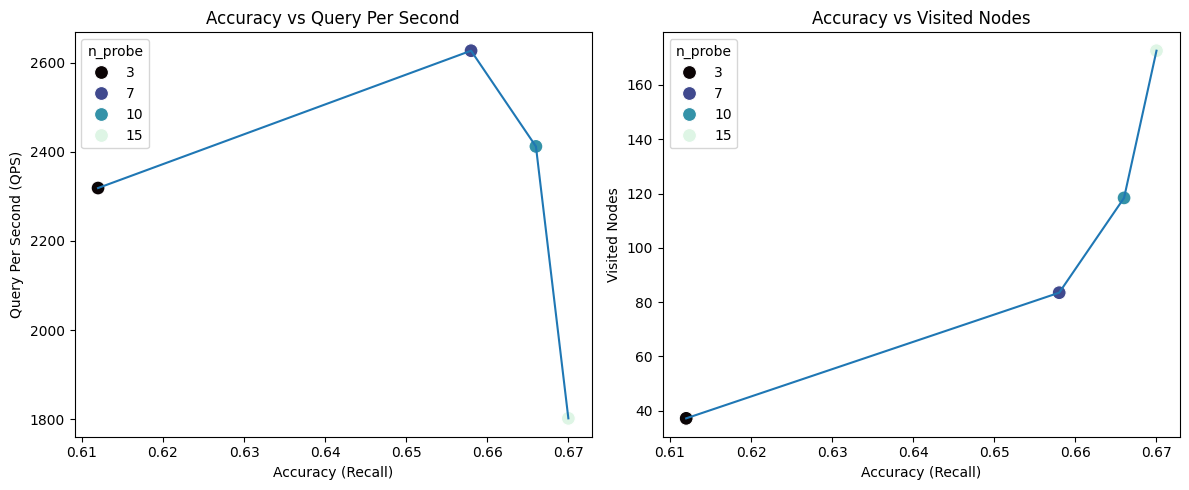

In [45]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.lineplot(x=accuracies_ivf, y=qps_ivf)
sns.scatterplot(x=accuracies_ivf, y=qps_ivf, hue=n_probes, s=100, legend="full", palette = "mako")
plt.xlabel("Accuracy (Recall)")
plt.ylabel("Query Per Second (QPS)")
plt.legend(title="n_probe")
plt.title("Accuracy vs Query Per Second")

plt.subplot(1, 2, 2)
sns.lineplot(x=accuracies_ivf, y=visited_ivf)
sns.scatterplot(x=accuracies_ivf, y=visited_ivf, hue=n_probes, s=100, palette = "mako")
plt.xlabel("Accuracy (Recall)")
plt.ylabel("Visited Nodes")
plt.legend(title="n_probe")
plt.title("Accuracy vs Visited Nodes")

plt.tight_layout()
plt.show()

In [57]:
hnsw = HNSWBQ("cosine", M = 16, efConstruction=64)

for i in range(len(train)):
    hnsw.insert(train[i])

In [58]:
efs = [10, 20, 30, 50, 100]
accuracies_hnsw = []
qps_hnsw = []
visited_hnsw = []

for ef in efs:

    query_acc = []
    query_per_second = []
    query_visit = []

    for i in range(len(test)):
        start = time.time()
        search_result = hnsw.search(test[i], 5, ef)
        query_per_second.append(time.time() - start)

        acc = len(set(neighbors[i][:5]) & set([idx for idx, _ in search_result])) / 5
        query_acc.append(acc)

        query_visit.append(hnsw.visited_count)

    qps_hnsw.append(1 / np.mean(query_per_second))
    accuracies_hnsw.append(np.mean(query_acc))
    visited_hnsw.append(np.mean(query_visit))


for ef, acc, qp, v in zip(efs, accuracies_hnsw, qps_hnsw, visited_hnsw):
    print(f"ef : {ef}, accuracy : {acc}, qps : {qp}, visited : {v}")


ef : 10, accuracy : 0.6679999999999999, qps : 640.4016190573617, visited : 204.66
ef : 20, accuracy : 0.674, qps : 563.1676893537602, visited : 278.74
ef : 30, accuracy : 0.672, qps : 453.820460690679, visited : 337.54
ef : 50, accuracy : 0.672, qps : 365.15074217559743, visited : 427.72
ef : 100, accuracy : 0.6759999999999999, qps : 248.21833108055327, visited : 549.52


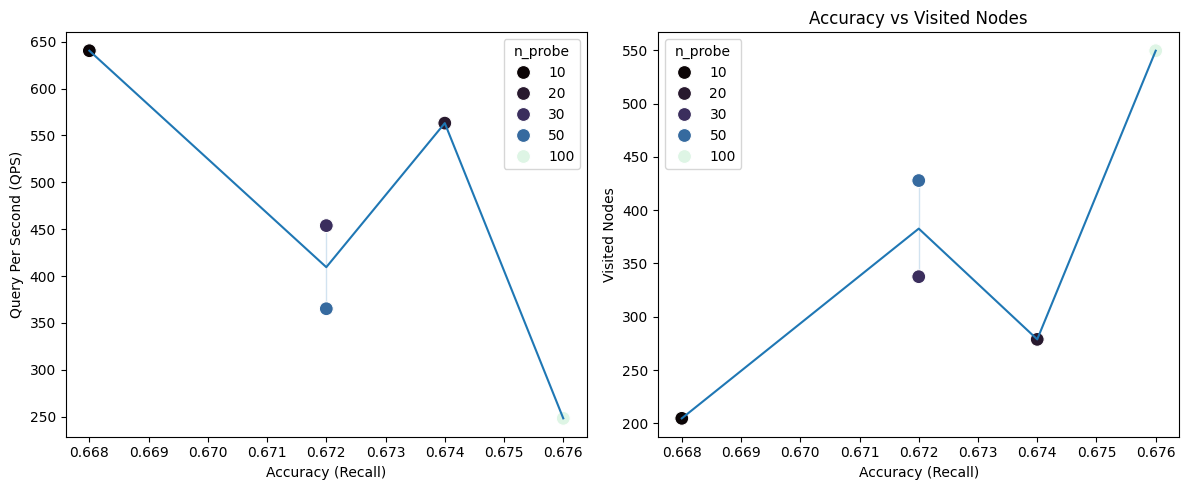

In [59]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.lineplot(x=accuracies_hnsw, y=qps_hnsw)
sns.scatterplot(x=accuracies_hnsw, y=qps_hnsw, hue=efs, s=100, legend="full", palette = "mako")
plt.xlabel("Accuracy (Recall)")
plt.ylabel("Query Per Second (QPS)")
plt.legend(title="n_probe")


plt.subplot(1, 2, 2)
sns.lineplot(x=accuracies_hnsw, y=visited_hnsw)
sns.scatterplot(x=accuracies_hnsw, y=visited_hnsw, hue=efs, s=100, palette = "mako")
plt.xlabel("Accuracy (Recall)")
plt.ylabel("Visited Nodes")
plt.legend(title="n_probe")
plt.title("Accuracy vs Visited Nodes")

plt.tight_layout()
plt.show()